## Wstęp
Plik ten jest częścią pracy magisterskiej pt. **Wykorzystanie technik uczenia maszynowego w medycynie** <br>
W tym pliku została zawarta analiza bazy danych pacjentów z chorobami serca. <br><br>

**Miedzy innymi znajduje się tutaj:**
* Analiza danych pacjentów 
* Znalezienie jakie czynniki najbardziej wpływają na chorobe serca
* Proces przetwarzania danych
* Stworzenie modeli predykcji

### Wyjaśnienie pojęć pochodzących z bazy danych
* age: Wiek pacjenta
* sex: Płeć (1 = mężczyzna, 0 = kobieta)
* cp: Rodzaj bólu w klatce piersiowej (0: typical angina, 1: atypical angina, 2: non-anginal pain, 3: * asymptomatic)
* trestbps: Spoczynkowe ciśnienie krwi (mm Hg przy przyjęciu do szpitala)
* chol: Poziomu cholesterolu mg/dl
* fbs: Poziom cukru we krwi osoby na czczo (> 120 mg/dl, 1 = true; 0 = false)
* restecg: Spoczynkowy pomiar elektrokardiograficzny (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or * definite left ventricular hypertrophy by Estes' criteria)
* thalach: Maksymalne osiągnięte tętno
* exang: Czy wysiłek fizyczny prowadzi do dławicy piersiowej  (1 = yes; 0 = no)
* oldpeak: Obniżenie odcinka ST wywołane wysiłkiem fizycznym w stosunku do spoczynku 
* slope: Odchylenie szczytowego wysiłkowego odcinka ST (1: upsloping, 2: flat, 3: downsloping)
* ca: liczba głównych naczyń (0-3)
* thal: Zaburzenie krwi zwane talasemią (1 = normal; 2 = fixed defect; 3 = reversable defect)
* target: Czy wykryto chorobe serca (0 = no, 1 = yes)

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math


In [2]:
# Wczytanie danych i przedstawienie kilku pierwszych wartości
dataset = pd.read_csv('Data/heart.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Przetwarzanie danych

Zaczniemy od zmiany nazw w zestawie danych, abyśmy mogli lepiej zrozumieć, co dzieje się na wykresach.

In [36]:
dt = dataset.copy()  # stworzenie kopi danych

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['cp'][dt['cp'] == 0] = 'typical angina'
dt['cp'][dt['cp'] == 1] = 'atypical angina'
dt['cp'][dt['cp'] == 2] = 'non-anginal pain'
dt['cp'][dt['cp'] == 3] = 'asymptomatic'

dt['slope'][dt['slope'] == 0] = 'upsloping'
dt['slope'][dt['slope'] == 1] = 'flat'
dt['slope'][dt['slope'] == 2] = 'downsloping'

dt['thal'][dt['thal'] == 1] = 'normal'
dt['thal'][dt['thal'] == 2] = 'fixed defect'
dt['thal'][dt['thal'] == 3] = 'reversable defect'

dt['target'][dt['target'] == 0] = 'healthy'
dt['target'][dt['target'] == 1] = "sick"

In [4]:
# Ponowne wyświetlenie danych po przetworzeniu nazw
dt.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,asymptomatic,145,233,1,0,150,0,2.3,upsloping,0,normal,sick
1,37,male,non-anginal pain,130,250,0,1,187,0,3.5,upsloping,0,fixed defect,sick
2,41,female,atypical angina,130,204,0,0,172,0,1.4,downsloping,0,fixed defect,sick
3,56,male,atypical angina,120,236,0,1,178,0,0.8,downsloping,0,fixed defect,sick
4,57,female,typical angina,120,354,0,1,163,1,0.6,downsloping,0,fixed defect,sick


## Analiza danych

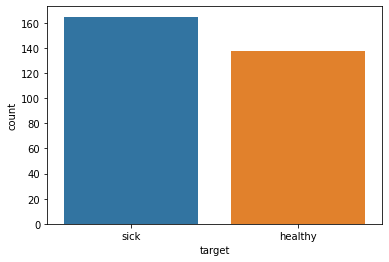

In [5]:
#f = plt.figure()

countplot = sns.countplot(x='target', data=dt)
#f.savefig('balance.png', format='png', dpi=300)

Powyższy wykres przedstawia liczbe chorych i zdrowych pacjentów w bazie danych. Zbalansowane dane są istotne do prawidłowej analizy danych. Jak widać na wykresie liczba chorych i zdrowych pacjentów jest mniej wiecej podobna.

In [6]:
# Liczba wierszy w bazie danych
len(dt) 

303

303 wiersze nie jest wiele jednak może wystarczyć do przedstawienia problemu, wizualizacji danych oraz do stworzenia prostych modeli predykcji. Aby w pełni przeanalizować choroby serca i stworzyć model predykcyjny o dokładności co najmniej 95% musielibyśmy mieć znacznie wiekszą bazę danych pacjentów.

#### Wiek

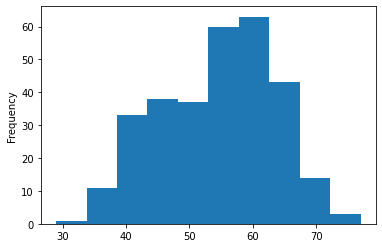

In [7]:
dt["age"] = dt["age"].astype(float)
# Rozkładu wieku wszystkich osób w bazie danych
dt["age"].plot.hist()

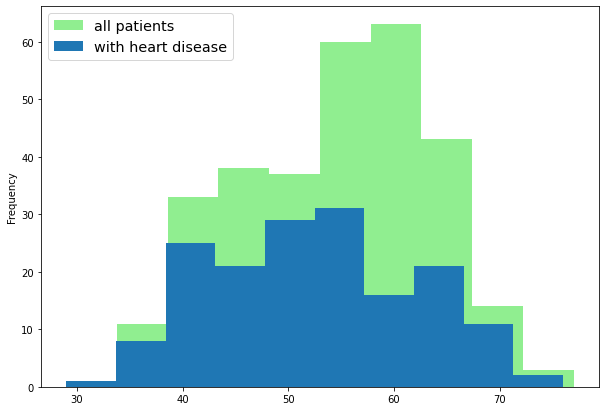

In [8]:
# Rozkładu wieku osób chorych
#f = plt.figure()
fig, ax = plt.subplots(figsize=(10,7))

temp = dt[dt["target"]=='sick']
dt["age"].plot.hist(color='lightgreen', label='all patients')
temp["age"].plot.hist( label='with heart disease')

plt.legend(fontsize='x-large', title_fontsize='40')
#fig.savefig('age.png', format='png', dpi=300)

In [9]:
dt["age"].mean() # the age mean

54.366336633663366

Wyraźnie widać, że większość pacjentów w zbiorze danych to osoby powyżej 50 lat. Średnia wieku wynosi 54 lata co nie jest niczym zaskakującym. Większość osób z problami serca to osoby starsze. Co jest bardziej interesujące, to mniejsza liczba osób w wieku powyżej 65 lat. Jednak jest to tylko mały zbiór danych, więc nie możemy być pewni, dlaczego jest mniej dużo starszych osób (65 lat i więcej). W przedziale 40 - 65 lat jest nawiecej pacjentów u których wykryto chorobe serca.

#### Płeć
Wiemy też, że płeć odgrywa znaczącą role przy chorobach serca. Najczęściej na choroby serca zapadają mężczyźni. Sprawdźmy więc liczbe kobiet i mężczyzn w zbiorze danych.

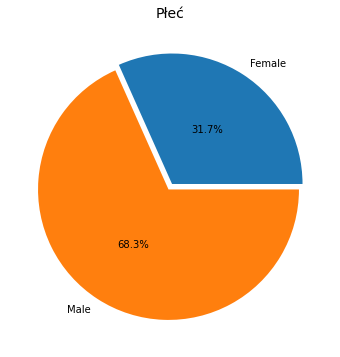

In [10]:
pie, ax = plt.subplots(figsize=[10,6])
data = dt.groupby("sex").size()  # data for Pie chart
labels = ['Female', 'Male']
plt.pie(x=data, autopct="%.1f%%", explode=[0.025]*2,labels=labels, pctdistance=0.5)
plt.title("Płeć", fontsize=14);

In [11]:
# Liczba mężczyzn
len(dt[(dt['sex']=='male')])

207

In [12]:
# Liczba kobiet
len(dt[(dt['sex']=='female')])

96

Aby przedstawić liczbe mężczyzn i kobiet wykorzystałem diagram kołowy. Jak widać ponad 2/3 pacjentów to mężczyźni 

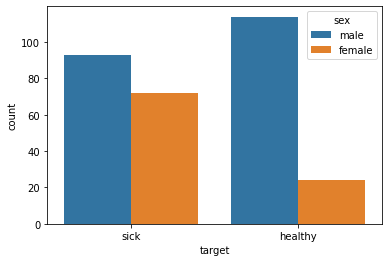

In [13]:

sns.countplot(x='target', hue='sex', data=dt)

Powyższy wykres pokazuje, że mężczyźni dominują w grupie osób chorych i zdrowych. Trzeba mieć jednak na uwadzę, że badana grupa osób jest nie wielka i składa się w wiekszośći z mężczyzn

#### Rodzaj bólu w klatce piersiowej

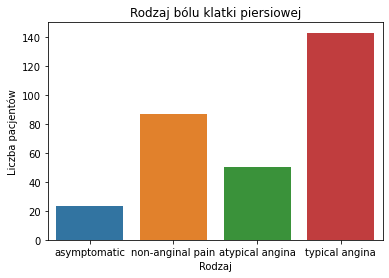

In [14]:
#f = plt.figure()

sns.countplot(dt['cp'])
plt.xlabel('Rodzaj')
plt.ylabel('Liczba pacjentów')
plt.title('Rodzaj bólu klatki piersiowej')
plt.show()
#f.savefig('chest_pain.png', format='png', dpi=300)

Wyraźnie widać, że przeważa zwykły rodzaj bólu w klatce piersiowej. Sprawdźmy czy oraz jaki rodzaj bólu najbardziej decyduje o chorobie serca

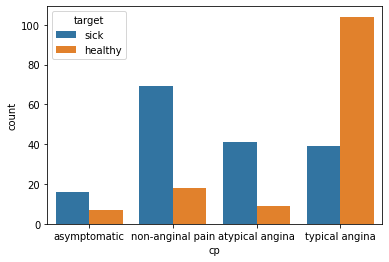

In [15]:
#f = plt.figure()
sns.countplot(x="cp", hue="target", data=dt)
#f.savefig('chest_pain_compare.png', format='png', dpi=300)

Pomarańczowy słupek oznacza liczbe pacjentów zdrowych. Niebieski to pacjenci u których wykryto chorobę serca. <br>
*Typical angina* czyli zwykły rodzaj bólu klatki piersiowej w znacznej wiekszości nie oznacza choroby serca. Gdy jednak spojrzymy na pozostałe słupki to najwiecej osób chorych cierpi na *non-anginal pain*. Przy *Atypical angina* również jest znacznie wiecej osób dotknętych chorobą serca.

#### ca: liczba głównych naczyń

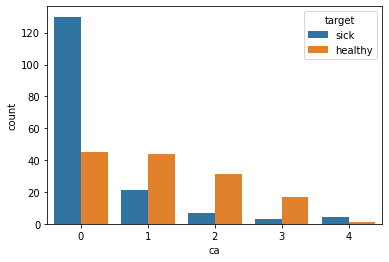

In [16]:
f = plt.figure()
sns.countplot(x="ca", hue="target", data=dt)
f.savefig('ca.png', format='png', dpi=300)

Widzimy, że liczba pacjentów chorych znacząco spada, gdy liczba *ca* wzrasta, ale co to oznacza?
Oznacza to, że gdy wzrasta liczba *ca*, prawdopodobieństwo wystąpienia choroby serca maleje. Już przy wartości 1 liczba chorych spadła z ponad 120 do okoła 20.

## Szukanie przyczyny choroby
Wykorzystamy do tego algorytm losowego lasu decyzyjnego

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('target', 1), dataset['target'], test_size = .2, random_state=10)

model = RandomForestClassifier(max_depth=4)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [18]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'Zdrowy'
y_train_str[y_train_str == '1'] = 'Chory'
y_train_str = y_train_str.values

In [19]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

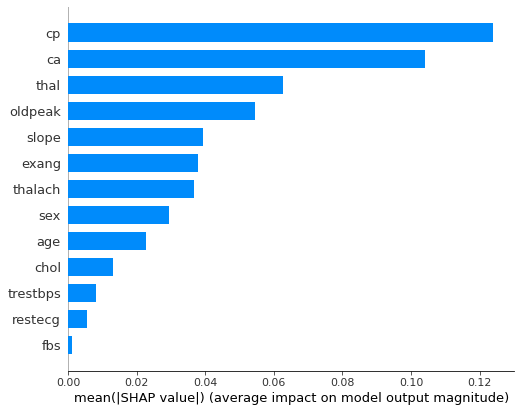

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [21]:
# Przetworzenie danych ponownie, aby sprawdzić co dokładnie ma najwiekszy wpływ na chorobe serca

dt['sex'] = dt['sex'].astype('object')
dt['cp'] = dt['cp'].astype('object')
dt['trestbps'] = dt['trestbps'].astype('int')
dt['fbs'] = dt['fbs'].astype('int')
dt['restecg'] = dt['restecg'].astype('object')
dt['exang'] = dt['exang'].astype('object')
dt['slope'] = dt['slope'].astype('object')
dt['thal'] = dt['thal'].astype('object')

dt.dtypes

age         float64
sex          object
cp           object
trestbps      int32
chol          int64
fbs           int32
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target       object
dtype: object

In [22]:
pdt = pd.get_dummies(dt, drop_first=True)

pdt.head() # Wygląd bazy danych po jej przetworzeniu

,age,trestbps,chol,fbs,thalach,oldpeak,ca,sex_male,cp_atypical angina,cp_non-anginal pain,cp_typical angina,restecg_1,restecg_2,exang_1,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,target_sick
0,63.0,145,233,1,150,2.3,0,1,0,0,0,0,0,0,0,1,0,1,0,1
1,37.0,130,250,0,187,3.5,0,1,0,1,0,1,0,0,0,1,1,0,0,1
2,41.0,130,204,0,172,1.4,0,0,1,0,0,0,0,0,0,0,1,0,0,1
3,56.0,120,236,0,178,0.8,0,1,1,0,0,1,0,0,0,0,1,0,0,1
4,57.0,120,354,0,163,0.6,0,0,0,0,1,1,0,1,0,0,1,0,0,1


In [23]:
# Po przetworzeniu bazy danych musimy ponownie nauczyć model

X_train, X_test, y_train, y_test = train_test_split(pdt.drop('target_sick', 1), pdt['target_sick'], test_size = .2, random_state=10)

model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

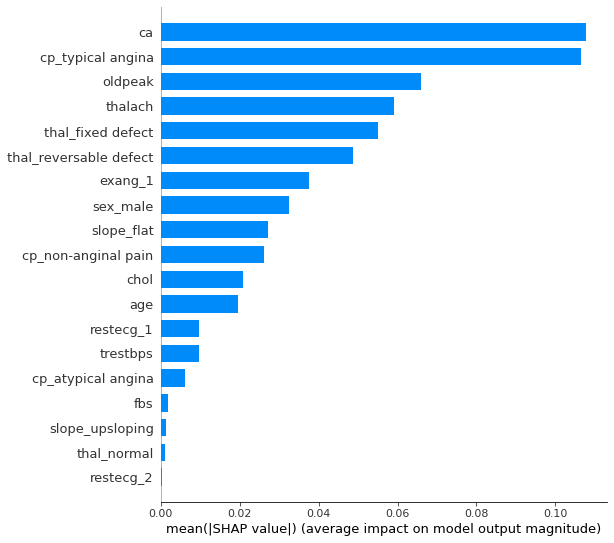

In [24]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
#f = plt.figure()
test = shap.summary_plot(shap_values[1], X_test, plot_type="bar")
#f.savefig('parameters2.png', format='png', dpi=300, bbox_inches='tight')

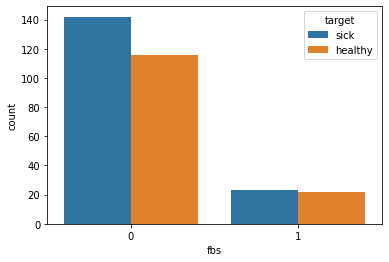

In [25]:
#f = plt.figure()
sns.countplot(x="fbs", hue="target", data=dt)
#f.savefig('fbs.png', format='png', dpi=300)

### Wynik
Po przetworzeniu danych (rozbiciu danych na osobne kolumny czyli np: kolumna **cp**, która przedstawia 4 wartości została rozbita na 4 osobne kolumny **cp_typical angina**, **cp_atypical angina**, **cp_non-anginal pain** i **cp_asymptomatic**) uzyskaliśmy powyższy wykres. Dzięki takiemu rozbicu możemy dokładnie odnaleźć na wykresie jakie wartości odpowiadają za chorobe serca.

Na powyższym wykresie na pierwszym miejscu plasuje się **ca**. Na wykresie w bloku 16 został przedstawiony wykres przedstawiający dokładniej tą wartość. Można tam zauważyć, że ponad 70% pacjentów z ca równym 0 ma chore serce.

Na drugim miejscu widzimy typical angina czyli typowy rodzaj bólu w klatce piersiowej. Wyżej w bloku 15 można zauważyć, że znaczna większość osób z typical angina nie ma choroby serca. Dlatego też pojawiła się ona tutaj na drugim miejscu. Brak typical angina (<i>posiadanie innego rodzaju bólu klatki piersiowej</i>) ma znaczący wpływ na końcowy wynik pacjenta. Warto tutaj wspomnieć, że te wyniki tyczą się jedynie tego zbioru danych i moge nie przekładać się w pełni na rzeczywistość.

Na trzecim miejscu jest parametr thal z wartością fixed defect.

Następnie jest **oldpeak**, aby dowiedzieć się dokładniej jakie wartości tego pola zwiększają prawdopodobieństo posiadania choroby serca należy zbudować kolejny wykres.

In [26]:
sick = dt[dt["target"] == "sick"]
healthy = dt[dt["target"] == "healthy"]

oldpeak_sick = pd.Series(sick["oldpeak"], name="oldpeak")
oldpeak_healthy = pd.Series(healthy["oldpeak"], name="oldpeak")

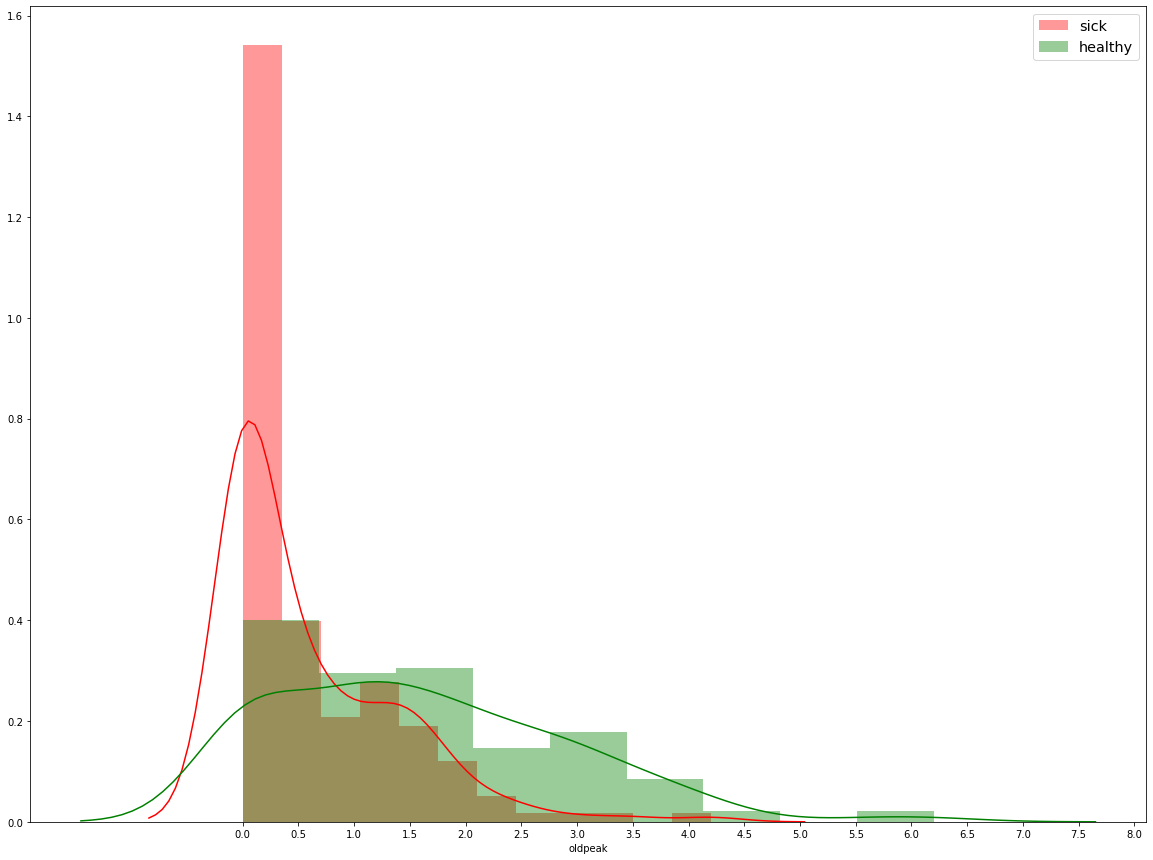

In [27]:
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(oldpeak_sick, color="red", label='sick')
sns.distplot(oldpeak_healthy, color="green", label='healthy')
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8])
plt.legend(fontsize='x-large', title_fontsize='40')
fig.savefig('oldpeak.png', format='png', dpi=300)

Widać, że osoby chore mają niższe wartości pola **oldpeak**. Pacjenci z wartościami bliskie zeru najcześciej chorują na serce. Dla wartości 2.5 i wiecej liczba chorych spada niemal do zera

## Modele predykcji
* Regresja logistyczna
* Regresja liniowa
* Naiwny klasyfikator bayesowski
* K najbliższych sąsiadów
* Losowy las decyzyjny

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('target', 1), dataset['target'], test_size = .2, random_state=20)

In [29]:
logistic_r = LogisticRegression(max_iter=5000)
logistic_r.fit(X_train,y_train)

# report = classification_report(y_test,y_pred)
# print(report)
# print(accuracy_score(y_test,y_pred))

LogisticRegression(max_iter=5000)

In [30]:
linear_r = LinearRegression()
linear_r.fit(X_train,y_train)


LinearRegression()

In [31]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [33]:
rfc=RandomForestClassifier(n_estimators=4, max_depth=5, random_state=20)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=4, random_state=20)

In [34]:
mlpc = MLPClassifier(hidden_layer_sizes=(50, 50, 50),
                        max_iter = 1000, 
                        learning_rate='constant',
                        activation = 'relu',
                        solver = 'adam')
mlpc.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000)

## Wyniki modeli predykcji

In [35]:
models = [logistic_r, linear_r, nb, knn, rfc, mlpc]
for model in models:
    name = model.__class__.__name__
    score_train =  round(model.score(X_train, y_train) * 100, 2)
    score_test = round(model.score(X_test, y_test) * 100, 2)
    print(name)
    print("Train accuracy: ", score_train, "%" )
    print("Test accuracy:  ", score_test, "%\n" )

LogisticRegression
Train accuracy:  85.95 %
Test accuracy:   73.77 %

LinearRegression
Train accuracy:  54.4 %
Test accuracy:   32.26 %

GaussianNB
Train accuracy:  85.54 %
Test accuracy:   67.21 %

KNeighborsClassifier
Train accuracy:  77.69 %
Test accuracy:   72.13 %

RandomForestClassifier
Train accuracy:  91.74 %
Test accuracy:   81.97 %

MLPClassifier
Train accuracy:  85.54 %
Test accuracy:   73.77 %



Z kilku wybranych modeli widać, że najlepiej poradził sobie model **Random Forest Classifier**. Osiągnał winik 82%, co oznacza, że z 82% prawdopodobieństwej jest wstanie przewidzieć czy dany pacjent jest chory na serce na podstawie wyników badań. Oczywiście 82% to o wiele za mało by można było użyć taki system szpitalu. System ten w 18% przypadków by się mylił sprawiając, że osoby chore nie dostały by odpowiedniego leczenia. Należy zaznaczyć jak już było wspomniane wcześniej, że zbiór danych jest bardzo mały (303 pacjentów) co bardzo ogranicza możliwości modeli predykcji. Jednak mając dostęp do dużo wiekszej bazy danych - 1000 lub więcej pacjentów, model mogłby się nauczyć przywidywać chorobe ze znacznie większą skutecznością.